# Imports

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
pip install -U tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 4.0 MB/s eta 0:00:00a 0:00:010m
  Attempting uninstall: tensorflow-addons
    Found existing installation: tensorflow-addons 0.14.0
    Uninstalling tensorflow-addons-0.14.0:
      Successfully uninstalled tensorflow-addons-0.14.0
Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install keras

Note: you may need to restart the kernel to use updated packages.


installing global context Vision Transformers.

In [ ]:
pip install -qU gcvit # stable

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.4.1 requires typing-extensions~=3.7.4, but you have typing-extensions 4.4.0 which is incompatible.
arviz 0.11.2 requires typing-extensions<4,>=3.7.4.3, but you have typing-extensions 4.4.0 which is incompatible.
aiobotocore 1.4.1 requires botocore<1.20.107,>=1.20.106, but you have botocore 1.21.44 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import math, re, os, random
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
import tensorflow as tf

print("Tensorflow version " + tf.__version__)

2022-12-06 18:11:00.644521: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-12-06 18:11:00.644687: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Tensorflow version 2.4.1


# Running on : GPU or TPU

In [ ]:
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470


2022-12-06 18:11:10.408722: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-12-06 18:11:10.412003: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-12-06 18:11:10.412057: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-06 18:11:10.412098: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (309c9c880e91): /proc/driver/nvidia/version does not exist
2022-12-06 18:11:10.416270: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

REPLICAS:  8


# Dataset Loading

In [ ]:
from kaggle_datasets import KaggleDatasets

GCS_DS_PATH = KaggleDatasets().get_gcs_path('tpu-getting-started')
print(GCS_DS_PATH) # what do gcs paths look like?

gs://kds-d7b82f69ae4c1edd7b18dfd0abb39a07caa73a75cac47fb43f2b7fef


In [ ]:
DIM = 224
IMAGE_SIZE = [DIM, DIM] # at this size, a GPU will run out of memory. Use the TPU
EPOCHS = 20
BATCH_SIZE = 32 * strategy.num_replicas_in_sync

NUM_TRAINING_IMAGES = 12753
NUM_TEST_IMAGES = 7382
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
AUTO = tf.data.experimental.AUTOTUNE

In [ ]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, label # returns a dataset of (image, label) pairs

def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "id": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
        # class is missing, this competitions's challenge is to predict flower classes for the test dataset
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['id']
    return image, idnum # returns a dataset of image(s)

def load_dataset(filenames, labeled=True, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls=AUTO)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset

def get_training_dataset():
    dataset = load_dataset(tf.io.gfile.glob(GCS_DS_PATH + F'/tfrecords-jpeg-{DIM}x{DIM}/train/*.tfrec'), labeled=True)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset():
    dataset = load_dataset(tf.io.gfile.glob(GCS_DS_PATH + F'/tfrecords-jpeg-{DIM}x{DIM}/val/*.tfrec'), labeled=True, ordered=False)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_test_dataset(ordered=False):
    dataset = load_dataset(tf.io.gfile.glob(GCS_DS_PATH + f'/tfrecords-jpeg-{DIM}x{DIM}/test/*.tfrec'), labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

training_dataset = get_training_dataset()
validation_dataset = get_validation_dataset()

2022-12-06 18:12:18.652700: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-12-06 18:12:18.912935: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


# Model

In [ ]:
# Learning rate schedule for TPU, GPU and CPU.
# Using an LR ramp up because fine-tuning a pre-trained model.
# Starting with a high LR would break the pre-trained weights.

LR_START = 0.00001
LR_MAX = 0.00005 * strategy.num_replicas_in_sync
LR_MIN = 0.00001
LR_RAMPUP_EPOCHS = 5
LR_SUSTAIN_EPOCHS = 0
LR_EXP_DECAY = .8

In [ ]:
def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr

Learning rate schedule: 1e-05 to 0.0004 to 1.56e-05


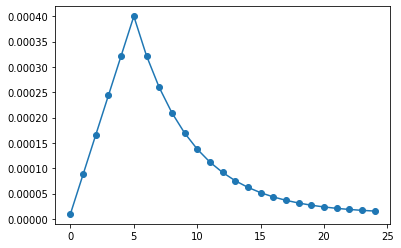

In [ ]:
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = False)

rng = [i for i in range(25 if EPOCHS<25 else EPOCHS)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y, '-o')
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

In [ ]:
from gcvit import GCViTTiny

In [ ]:
with strategy.scope():    
    model = GCViTTiny(input_shape=(*IMAGE_SIZE,3), pretrain=True)
    model.reset_classifier(num_classes=104, head_act='softmax')
        
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)

model.build_graph().summary()

113500160/113498376 [==============================] - 1s 0us/step
Model: "gcvit_tiny"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
patch_embed (Stem)           (None, 56, 56, 64)        45632     
_________________________________________________________________
pos_drop (Dropout)           (None, 56, 56, 64)        0         
_________________________________________________________________
tf.cast (TFOpLambda)         (None, 56, 56, 64)        0         
_________________________________________________________________
levels/0 (GCViTLevel)        (None, 28, 28, 128)       223030    
_________________________________________________________________
levels/1 (GCViTLevel)        (None, 14, 14, 256)       1004048   
_______________________________________________________

In [ ]:
ckpt_path = 'model.h5'
ckpt_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=ckpt_path,
    save_best_only=True,
    save_weights_only=True,
    monitor='val_sparse_categorical_accuracy',
    mode='max',
    verbose=1)

In [ ]:
with strategy.scope():    
    history = model.fit(training_dataset, 
          steps_per_epoch=STEPS_PER_EPOCH, 
          epochs=EPOCHS, 
          validation_data=validation_dataset,
          callbacks=[lr_callback, ckpt_callback])

Epoch 1/20
49/49 [==============================] - 258s 1s/step - loss: 4.6154 - sparse_categorical_accuracy: 0.0188 - val_loss: 4.3768 - val_sparse_categorical_accuracy: 0.1018


2022-12-06 18:19:03.104256: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 53096, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1670350743.100562117","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 53096, Output num: 0","grpc_status":3}



Epoch 00001: val_sparse_categorical_accuracy improved from -inf to 0.10183, saving model to model.h5
Epoch 2/20
49/49 [==============================] - 22s 457ms/step - loss: 3.7447 - sparse_categorical_accuracy: 0.2126 - val_loss: 1.4986 - val_sparse_categorical_accuracy: 0.6614

Epoch 00002: val_sparse_categorical_accuracy improved from 0.10183 to 0.66137, saving model to model.h5
Epoch 3/20
49/49 [==============================] - 22s 458ms/step - loss: 1.3380 - sparse_categorical_accuracy: 0.6993 - val_loss: 0.4762 - val_sparse_categorical_accuracy: 0.8798

Epoch 00003: val_sparse_categorical_accuracy improved from 0.66137 to 0.87985, saving model to model.h5
Epoch 4/20
49/49 [==============================] - 22s 457ms/step - loss: 0.4815 - sparse_categorical_accuracy: 0.8879 - val_loss: 0.3106 - val_sparse_categorical_accuracy: 0.9230

Epoch 00004: val_sparse_categorical_accuracy improved from 0.87985 to 0.92295, saving model to model.h5
Epoch 5/20
49/49 [======================

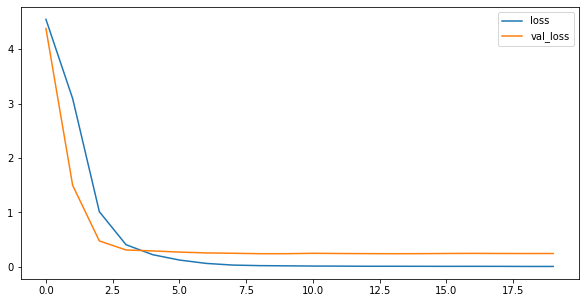

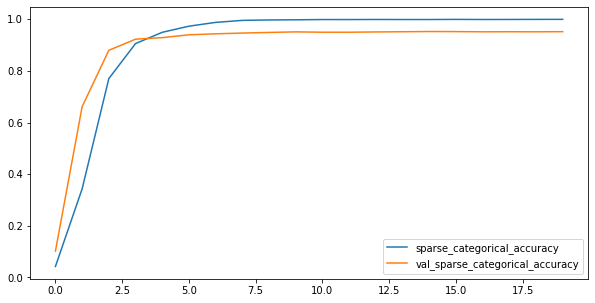

In [ ]:
import pandas as pd
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10, 5)
data = pd.DataFrame(history.history)
metrics = ['loss', 'sparse_categorical_accuracy']
for metric in metrics:
    data[[f'{metric}',f'val_{metric}']].plot()

In [ ]:
# load best model
model.load_weights(ckpt_path)

In [ ]:
# infer
test_ds = get_test_dataset(ordered=True) # since we are splitting the dataset and iterating separately on images and ids, order matters.

print('Computing predictions...')
test_images_ds = test_ds.map(lambda image, idnum: image)
probabilities = model.predict(test_images_ds, verbose=1)
predictions = np.argmax(probabilities, axis=-1)
print(predictions)

2022-12-06 18:27:44.202951: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


Computing predictions...
29/29 [==============================] - 56s 808ms/step
[ 67  28  83 ...  86 102  62]


2022-12-06 18:28:40.751980: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 107697, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1670351320.751823296","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 107697, Output num: 0","grpc_status":3}


In [ ]:
print('Generating submission.csv file...')
test_ids_ds = test_ds.map(lambda image, idnum: idnum).unbatch()
test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U') # all in one batch

Generating submission.csv file...


In [ ]:
np.savetxt('submission.csv', np.rec.fromarrays([test_ids, predictions]), fmt=['%s', '%d'], delimiter=',', header='id,label', comments='')

# running model for 50 epochs

In [ ]:
# Learning rate schedule for TPU, GPU and CPU.
# Using an LR ramp up because fine-tuning a pre-trained model.
# Starting with a high LR would break the pre-trained weights.

LR_START = 0.00003
LR_MAX = 0.00015 * strategy.num_replicas_in_sync
LR_MIN = 0.00002
LR_RAMPUP_EPOCHS = 5
LR_SUSTAIN_EPOCHS = 0
LR_EXP_DECAY = .8

In [ ]:
def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr

Learning rate schedule: 1e-05 to 0.0004 to 1.56e-05


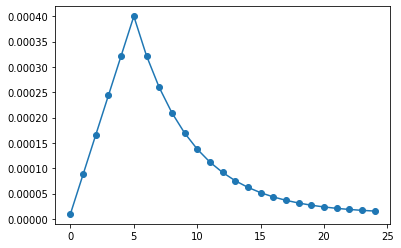

In [ ]:
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = False)

rng = [i for i in range(25 if EPOCHS<25 else EPOCHS)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y, '-o')
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

In [ ]:
from gcvit import GCViTTiny

In [ ]:
with strategy.scope():    
    model = GCViTTiny(input_shape=(*IMAGE_SIZE,3), pretrain=True)
    model.reset_classifier(num_classes=104, head_act='softmax')
        
model.compile(
    optimizer='sgd',
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)

model.build_graph().summary()

113500160/113498376 [==============================] - 1s 0us/step
Model: "gcvit_tiny"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
patch_embed (Stem)           (None, 56, 56, 64)        45632     
_________________________________________________________________
pos_drop (Dropout)           (None, 56, 56, 64)        0         
_________________________________________________________________
tf.cast (TFOpLambda)         (None, 56, 56, 64)        0         
_________________________________________________________________
levels/0 (GCViTLevel)        (None, 28, 28, 128)       223030    
_________________________________________________________________
levels/1 (GCViTLevel)        (None, 14, 14, 256)       1004048   
_______________________________________________________

In [ ]:
ckpt_path = 'model.h5'
ckpt_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=ckpt_path,
    save_best_only=True,
    save_weights_only=True,
    monitor='val_sparse_categorical_accuracy',
    mode='max',
    verbose=1)

In [ ]:
with strategy.scope():    
    history = model.fit(training_dataset, 
          steps_per_epoch=STEPS_PER_EPOCH, 
          epochs=EPOCHS, 
          validation_data=validation_dataset,
          callbacks=[lr_callback, ckpt_callback])

Epoch 1/50
49/49 [==============================] - 23s 459ms/step - loss: 0.0091 - sparse_categorical_accuracy: 0.9994 - val_loss: 0.2426 - val_sparse_categorical_accuracy: 0.9523


2022-12-06 18:32:16.709056: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 108747, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1670351536.708534554","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 108747, Output num: 0","grpc_status":3}



Epoch 00001: val_sparse_categorical_accuracy did not improve from 0.95259
Epoch 2/50
49/49 [==============================] - 23s 460ms/step - loss: 0.0091 - sparse_categorical_accuracy: 0.9996 - val_loss: 0.2435 - val_sparse_categorical_accuracy: 0.9512

Epoch 00002: val_sparse_categorical_accuracy did not improve from 0.95259
Epoch 3/50
49/49 [==============================] - 22s 459ms/step - loss: 0.0096 - sparse_categorical_accuracy: 0.9995 - val_loss: 0.2467 - val_sparse_categorical_accuracy: 0.9504

Epoch 00003: val_sparse_categorical_accuracy did not improve from 0.95259
Epoch 4/50
49/49 [==============================] - 22s 459ms/step - loss: 0.0096 - sparse_categorical_accuracy: 0.9995 - val_loss: 0.2612 - val_sparse_categorical_accuracy: 0.9494

Epoch 00004: val_sparse_categorical_accuracy did not improve from 0.95259
Epoch 5/50
49/49 [==============================] - 23s 460ms/step - loss: 0.0102 - sparse_categorical_accuracy: 0.9988 - val_loss: 0.3023 - val_sparse_categ

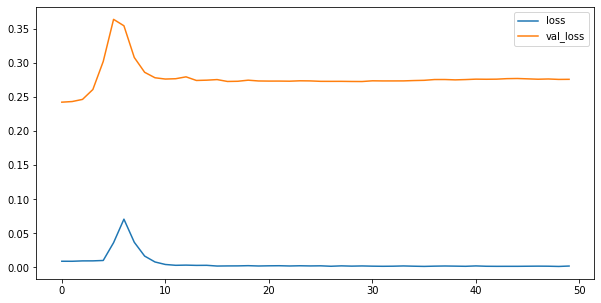

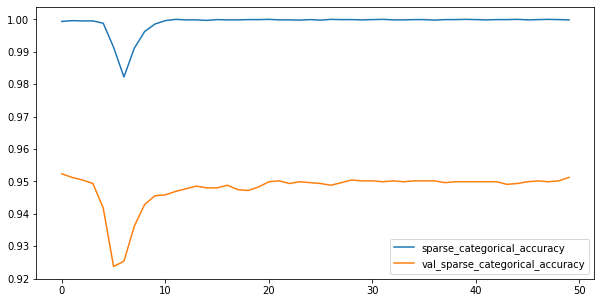

In [ ]:
import pandas as pd
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10, 5)
data = pd.DataFrame(history.history)
metrics = ['loss', 'sparse_categorical_accuracy']
for metric in metrics:
    data[[f'{metric}',f'val_{metric}']].plot()

In [ ]:
# load best model
model.load_weights(ckpt_path)

In [ ]:
# infer
test_ds = get_test_dataset(ordered=True) # since we are splitting the dataset and iterating separately on images and ids, order matters.

print('Computing predictions...')
test_images_ds = test_ds.map(lambda image, idnum: image)
probabilities = model.predict(test_images_ds, verbose=1)
predictions = np.argmax(probabilities, axis=-1)
print(predictions)

2022-12-06 18:53:58.454221: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


Computing predictions...
29/29 [==============================] - 5s 123ms/step
[ 67  28  83 ...  86 102  62]


2022-12-06 18:54:03.579969: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 166499, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1670352843.579887435","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 166499, Output num: 0","grpc_status":3}


In [ ]:
print('Generating submission.csv file...')
test_ids_ds = test_ds.map(lambda image, idnum: idnum).unbatch()
test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U') # all in one batch

Generating submission.csv file...


In [ ]:
np.savetxt('submission.csv', np.rec.fromarrays([test_ids, predictions]), fmt=['%s', '%d'], delimiter=',', header='id,label', comments='')

The model didn't improve from the first epoch at all for the new hyperparameters. However, the model is ran fro 50 epochs to compare the performnace on GPU and TPU. The first version of vision transformers was run using early stopping at 12 epochs.
The f-1 score for the first version is : 0.9411
The f-1 score for the sceond version is : 0.956